<a href="https://colab.research.google.com/github/nancy-kataria/NexTrade/blob/main/product_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

--- Download Dataset ---

In [2]:
# Download latest version
print("Dowlaod Dataset...")
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")
print(f"Dataset downloaded to: {path}")
csv_file_path = path + "/Sample - Superstore.csv"
print(f"Reading data from: {csv_file_path}")

Dowlaod Dataset...
Dataset downloaded to: /kaggle/input/superstore-dataset-final
Reading data from: /kaggle/input/superstore-dataset-final/Sample - Superstore.csv


--- Data Loading and Initial Cleaning ---

In [3]:
try:
    superstore_data = pd.read_csv(csv_file_path, encoding='ISO-8859-1')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: File not found at {csv_file_path}.")
    exit()

Data loaded successfully.


In [4]:
# Keep only the columns we need for recommendations.
columns_to_keep = ['Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'Country', 'City', 'State', 'Postal Code', 'Product ID', 'Product Name', 'Sales', 'Quantity', 'Category', 'Sub-Category']
superstore_data = superstore_data[columns_to_keep]

In [5]:
# Display the first 5 rows to check the data
print("First 5 rows of data:")
print(superstore_data.head())

First 5 rows of data:
         Order ID  Order Date   Ship Date Customer ID        Country  \
0  CA-2016-152156   11/8/2016  11/11/2016    CG-12520  United States   
1  CA-2016-152156   11/8/2016  11/11/2016    CG-12520  United States   
2  CA-2016-138688   6/12/2016   6/16/2016    DV-13045  United States   
3  US-2015-108966  10/11/2015  10/18/2015    SO-20335  United States   
4  US-2015-108966  10/11/2015  10/18/2015    SO-20335  United States   

              City       State  Postal Code       Product ID  \
0        Henderson    Kentucky        42420  FUR-BO-10001798   
1        Henderson    Kentucky        42420  FUR-CH-10000454   
2      Los Angeles  California        90036  OFF-LA-10000240   
3  Fort Lauderdale     Florida        33311  FUR-TA-10000577   
4  Fort Lauderdale     Florida        33311  OFF-ST-10000760   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon D

In [6]:
print("\nData types before conversion:")
print(superstore_data.dtypes)


Data types before conversion:
Order ID         object
Order Date       object
Ship Date        object
Customer ID      object
Country          object
City             object
State            object
Postal Code       int64
Product ID       object
Product Name     object
Sales           float64
Quantity          int64
Category         object
Sub-Category     object
dtype: object


In [7]:
# Convert 'Order Date' and 'Ship Date' from text (object) to actual date format.
superstore_data['Order Date'] = pd.to_datetime(superstore_data['Order Date'])
superstore_data['Ship Date'] = pd.to_datetime(superstore_data['Ship Date'])

In [8]:
# drop rows with missing any necessary columns
superstore_data.dropna(subset=columns_to_keep, inplace=True)

--- Pre-computation for Recommendations ---

1. Create a unique list of products

2. Create 'product_info' text feature for Content-Based Filtering

3. Calculate TF-IDF Matrix and Cosine Similarity

4. Create a mapping from Product ID to its index in our matrices/products_df

5. Calculate Product Popularity

--- Recommendation Functions ---

1. Popularity-Based Recommendation (Simple)

2. Popularity-Based Recommendation (Personalized with Category)

3. Content-Based Recommendation

4. Hybrid Recommendation (Content Similarity + Popularity)

5. Collaborative Recommendation

6. Hybrid Recommendation 2 (Content Similarity + Popularity + Collaborative)

--- Example Usage ---

--- Visualization ---

Popularity-Based Recommendation (Category consideration X) <br>
Current: recommend based on the popularity <br>
Future: recommend based on the populuarity while considering same categories purchased in the past

In [9]:
# get product popularity based on the total quntity sold
popular_by_quantity = superstore_data.groupby('Product ID').agg({
    'Quantity': 'sum',
    'Product Name': 'first',
    'Category': 'first'
}).sort_values(by='Quantity', ascending=False).reset_index()


popular_by_sales = superstore_data.groupby('Product ID').agg({
    'Sales': 'sum',
    'Product Name': 'first',
    'Category': 'first'
}).sort_values(by='Sales', ascending=False).reset_index()

In [11]:
product_popularity = superstore_data.groupby('Product ID').agg({
    'Product Name': 'first',
    'Category': 'first',
    'Sub-Category': 'first',
    'Quantity': 'sum',
    'Sales': 'sum'
}).reset_index()

print(product_popularity)

           Product ID                                       Product Name  \
0     FUR-BO-10000112   Bush Birmingham Collection Bookcase, Dark Cherry   
1     FUR-BO-10000330  Sauder Camden County Barrister Bookcase, Plank...   
2     FUR-BO-10000362                 Sauder Inglewood Library Bookcases   
3     FUR-BO-10000468            O'Sullivan 2-Shelf Heavy-Duty Bookcases   
4     FUR-BO-10000711                          Hon Metal Bookcases, Gray   
...               ...                                                ...   
1857  TEC-PH-10004912                  Cisco SPA112 2 Port Phone Adapter   
1858  TEC-PH-10004922             RCA Visys Integrated PBX 8-Line Router   
1859  TEC-PH-10004924  SKILCRAFT Telephone Shoulder Rest, 2" x 6.5" x...   
1860  TEC-PH-10004959             Classic Ivory Antique Telephone ZL1810   
1861  TEC-PH-10004977                                        GE 30524EE4   

        Category Sub-Category  Quantity     Sales  
0      Furniture    Bookcases      

In [12]:
# get top N products
def recommend_popular_products(n=10, by='Quantity'):
    if by not in ['Quantity', 'Sales']:
        raise ValueError("Parameter 'by' must be either 'Quantity' or 'Sales'")

    return product_popularity.sort_values(by=by, ascending=False).head(n)[
        ['Product ID', 'Product Name', 'Category', 'Sub-Category', by]
    ]

# get top N products that the user not already bought
def recommend_popular_products_to_customer(customer_id, n=10, by='Quantity'):
    if by not in ['Quantity', 'Sales']:
        raise ValueError("Parameter 'by' must be either 'Quantity' or 'Sales'")

    purchased = superstore_data[superstore_data['Customer ID'] == customer_id]['Product ID'].unique()
    recommendations = product_popularity[~product_popularity['Product ID'].isin(purchased)]

    if recommendations.empty:
        return recommend_popular_products(n, by=by)

    recommendations = recommendations.sort_values(by=by, ascending=False)
    return recommendations.head(n)[['Product ID', 'Product Name', 'Category', 'Sub-Category', by]]

In [13]:
recommend_popular_products(5)

,Product ID,Product Name,Category,Sub-Category,Quantity
1569,TEC-AC-10003832,Logitech P710e Mobile Speakerphone,Technology,Accessories,75
1144,OFF-PA-10001970,Xerox 1881,Office Supplies,Paper,70
694,OFF-BI-10001524,GBC Premium Transparent Covers with Diagonal L...,Office Supplies,Binders,67
721,OFF-BI-10002026,Avery Arch Ring Binders,Office Supplies,Binders,64
93,FUR-CH-10002647,"Situations Contoured Folding Chairs, 4/Set",Furniture,Chairs,64


In [14]:
recommend_popular_products_to_customer('CG-12520', 5)

,Product ID,Product Name,Category,Sub-Category,Quantity
1569,TEC-AC-10003832,Logitech P710e Mobile Speakerphone,Technology,Accessories,75
1144,OFF-PA-10001970,Xerox 1881,Office Supplies,Paper,70
694,OFF-BI-10001524,GBC Premium Transparent Covers with Diagonal L...,Office Supplies,Binders,67
93,FUR-CH-10002647,"Situations Contoured Folding Chairs, 4/Set",Furniture,Chairs,64
721,OFF-BI-10002026,Avery Arch Ring Binders,Office Supplies,Binders,64


In [15]:
recommend_popular_products_to_customer('CG-12520', 5, by='Sales')

,Product ID,Product Name,Category,Sub-Category,Sales
1614,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,61599.824
776,OFF-BI-10003527,Fellowes PB500 Electric Punch Plastic Comb Bin...,Office Supplies,Binders,27453.384
1642,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,Technology,Machines,22638.480
80,FUR-CH-10002024,HON 5400 Series Task Chairs for Big and Tall,Furniture,Chairs,21870.576
691,OFF-BI-10001359,GBC DocuBind TL300 Electric Binding System,Office Supplies,Binders,19823.479


Popularity-Based Recommendation (Category consideration O)

In [ ]:
def get_customer_history(customer_id, df):
    return df[df['Customer ID'] == customer_id]

def get_customer_preferences(customer_id, df):
    customer_data = df[df['Customer ID'] == customer_id]
    if customer_data.empty:
        return [], []

    top_categories = customer_data['Category'].value_counts().index.tolist()
    top_subcategories = customer_data['Sub-Category'].value_counts().index.tolist()

    return top_categories, top_subcategories

In [ ]:
# Get a reference product table with unique info
product_info = superstore_data.sort_values('Quantity', ascending=False)
product_info = product_info.drop_duplicates('Product ID')[['Product ID', 'Category', 'Sub-Category']]

# Merge category info into popularity df
product_popularity = product_popularity.merge(product_info, on='Product ID', how='left')

In [ ]:
def personalized_popularity(customer_id, df, popularity_df, top_n=5):
    top_cats, top_subcats = get_customer_preferences(customer_id, df)

    if not top_cats or not top_subcats:
        print("No customer history found. Returning globally popular products.")
        return popularity_df.head(top_n)

    # Filter based on customer's preferred category/sub-category
    filtered = popularity_df[
      (popularity_df['Category'].isin(top_cats)) |
      (popularity_df['Sub-Category'].isin(top_subcats))
    ]


    # Remove products the customer already bought
    purchased_products = df[df['Customer ID'] == customer_id]['Product ID'].unique()
    filtered = filtered[~filtered['Product ID'].isin(purchased_products)]

    if filtered.empty:
      print("No new products in preferred categories. Showing global popular items instead.")
      return popularity_df[~popularity_df['Product ID'].isin(purchased_products)].head(top_n)


    return filtered.head(top_n)

In [ ]:
recommendations = personalized_popularity("CG-12520", superstore_data, product_popularity, top_n=5)
print(recommendations)

        Product ID                                       Product Name  \
0  OFF-BI-10001524  GBC Premium Transparent Covers with Diagonal L...   
1  FUR-CH-10002647         Situations Contoured Folding Chairs, 4/Set   
2  FUR-TA-10001095                 Chromcraft Round Conference Tables   
3  OFF-BI-10004728  Wilson Jones Turn Tabs Binder Tool for Ring Bi...   
4  FUR-CH-10003774    Global Wood Trimmed Manager's Task Chair, Khaki   

   Quantity         Category Sub-Category  
0        67  Office Supplies      Binders  
1        64        Furniture       Chairs  
2        61        Furniture       Tables  
3        59  Office Supplies      Binders  
4        59        Furniture       Chairs  


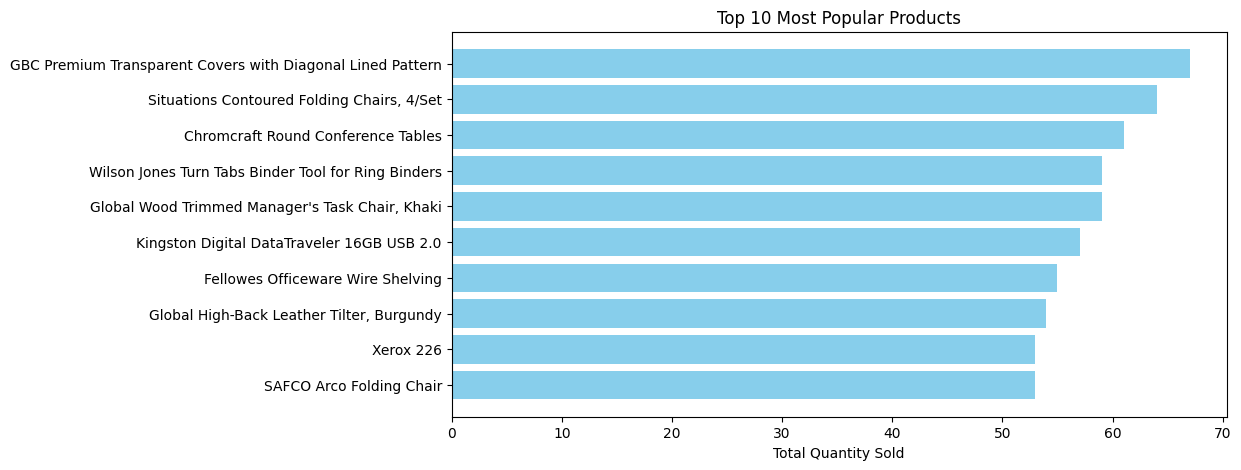

In [ ]:
# visualize top products
top10 = product_popularity.head(10)
plt.figure(figsize=(10,5))
plt.barh(top10['Product Name'], top10['Quantity'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Total Quantity Sold')
plt.title('Top 10 Most Popular Products')
plt.show()

content-based recommendation system

In [ ]:
# add product_info column combining 'Product Name', 'Category', and 'Sub-Category'
superstore_data['product_info'] = (
    superstore_data['Product Name'].astype(str) + ' ' +
    superstore_data['Category'].astype(str) + ' ' +
    superstore_data['Sub-Category'].astype(str)
)

In [ ]:
superstore_data

,Order ID,Order Date,Ship Date,Customer ID,Country,City,State,Postal Code,Product ID,Product Name,Sales,Quantity,Category,Sub-Category,product_info
0,CA-2016-152156,2016-11-08,2016-11-11,CG-12520,United States,Henderson,Kentucky,42420,FUR-BO-10001798,Bush Somerset Collection Bookcase,261.9600,2,Furniture,Bookcases,Bush Somerset Collection Bookcase Furniture Bo...
1,CA-2016-152156,2016-11-08,2016-11-11,CG-12520,United States,Henderson,Kentucky,42420,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
2,CA-2016-138688,2016-06-12,2016-06-16,DV-13045,United States,Los Angeles,California,90036,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...
3,US-2015-108966,2015-10-11,2015-10-18,SO-20335,United States,Fort Lauderdale,Florida,33311,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table ...
4,US-2015-108966,2015-10-11,2015-10-18,SO-20335,United States,Fort Lauderdale,Florida,33311,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,22.3680,2,Office Supplies,Storage,Eldon Fold 'N Roll Cart System Office Supplies...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2014-110422,2014-01-21,2014-01-23,TB-21400,United States,Miami,Florida,33180,FUR-FU-10001889,Ultra Door Pull Handle,25.2480,3,Furniture,Furnishings,Ultra Door Pull Handle Furniture Furnishings
9990,CA-2017-121258,2017-02-26,2017-03-03,DB-13060,United States,Costa Mesa,California,92627,FUR-FU-10000747,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...
9991,CA-2017-121258,2017-02-26,2017-03-03,DB-13060,United States,Costa Mesa,California,92627,TEC-PH-10003645,Aastra 57i VoIP phone,258.5760,2,Technology,Phones,Aastra 57i VoIP phone Technology Phones
9992,CA-2017-121258,2017-02-26,2017-03-03,DB-13060,United States,Costa Mesa,California,92627,OFF-PA-10004041,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x..."


In [ ]:
# Drop duplicates so we only have one row per product
products = superstore_data.drop_duplicates(subset='Product ID')[
    ['Product ID', 'Product Name', 'Category', 'Sub-Category', 'product_info']
]

# Fit the vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(products['product_info'])

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
product_indices = pd.Series(products.index, index=products['Product Name']).drop_duplicates()

In [ ]:
def recommend_similar_products(product_name, top_n=5):
    if product_name not in product_indices:
        return f"Product '{product_name}' not found."

    idx = product_indices[product_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    product_idxs = [i[0] for i in sim_scores]

    return products.iloc[product_idxs][['Product Name', 'Category', 'Sub-Category']]

In [ ]:
recommend_similar_products("Bush Somerset Collection Bookcase", 5)

,Product Name,Category,Sub-Category
3512,"Bush Birmingham Collection Bookcase, Dark Cherry",Furniture,Bookcases
906,"Bush Westfield Collection Bookcases, Fully Ass...",Furniture,Bookcases
292,"Bush Westfield Collection Bookcases, Medium Ch...",Furniture,Bookcases
2543,"Bush Westfield Collection Bookcases, Dark Cher...",Furniture,Bookcases
3102,"Bush Cubix Collection Bookcases, Fully Assembled",Furniture,Bookcases


In [ ]:
# Recommend to a customer (based on what they bought)
def recommend_to_customer_content_based(customer_id, top_n=5):
    customer_purchases = superstore_data[superstore_data['Customer ID'] == customer_id]
    if customer_purchases.empty:
        return f"No purchase history for customer '{customer_id}'."

    # Get last product bought
    last_product = customer_purchases.sort_values('Order Date', ascending=False).iloc[0]['Product Name']

    print(f"Based on last product: {last_product}")
    return recommend_similar_products(last_product, top_n)

In [ ]:
recommend_to_customer_content_based('CG-12520', 5)

Based on last product: SimpliFile Personal File, Black Granite, 15w x 6-15/16d x 11-1/4h


,Product Name,Category,Sub-Category
144,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,Office Supplies,Appliances
1995,3.6 Cubic Foot Counter Height Office Refrigerator,Office Supplies,Appliances
5434,Sanyo Counter Height Refrigerator with Crisper...,Office Supplies,Appliances
2190,Fellowes Mighty 8 Compact Surge Protector,Office Supplies,Appliances
2114,Mobile Personal File Cube,Office Supplies,Storage


Hybrid Recommendation (Popularity + Content-based)

In [ ]:
popularity_df = superstore_data.groupby('Product ID').agg({
    'Product Name': 'first',
    'Quantity': 'sum'  # or 'Sales'
}).reset_index()

# Normalize popularity score
popularity_df['popularity_score'] = popularity_df['Quantity'] / popularity_df['Quantity'].max()

In [ ]:
# Create text info for products
superstore_data['product_info'] = (
    superstore_data['Product Name'].astype(str) + ' ' +
    superstore_data['Category'].astype(str) + ' ' +
    superstore_data['Sub-Category'].astype(str)
)

# One row per product
products = superstore_data.drop_duplicates(subset='Product ID')[
    ['Product ID', 'Product Name', 'Category', 'Sub-Category', 'product_info']
]

# TF-IDF + cosine similarity
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['product_info'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Product index lookup
product_indices = pd.Series(products.index, index=products['Product ID']).drop_duplicates()

In [ ]:
def hybrid_recommendation(customer_id, top_n=5):
    customer_data = superstore_data[superstore_data['Customer ID'] == customer_id]
    if customer_data.empty:
        return "No purchase history found."

    # Products the customer has already bought
    purchased_ids = customer_data['Product ID'].unique()

    # Get the index of each purchased product
    purchased_idxs = [product_indices[pid] for pid in purchased_ids if pid in product_indices]

    # Accumulate similarity scores from all purchased products
    sim_scores = sum(cosine_sim[idx] for idx in purchased_idxs)

    # Normalize scores
    sim_scores = sim_scores / len(purchased_idxs)

    # Convert to dataframe
    scores_df = pd.DataFrame({
        'product_index': range(len(sim_scores)),
        'similarity_score': sim_scores
    })

    # Add product info
    scores_df = scores_df.merge(products.reset_index(), left_on='product_index', right_index=True)

    # Remove already purchased products
    scores_df = scores_df[~scores_df['Product ID'].isin(purchased_ids)]

    # Merge with popularity score
    scores_df = scores_df.merge(popularity_df[['Product ID', 'popularity_score']], on='Product ID', how='left')

    # Fill NaNs and compute hybrid score
    scores_df['popularity_score'] = scores_df['popularity_score'].fillna(0)
    scores_df['hybrid_score'] = 0.5 * scores_df['similarity_score'] + 0.5 * scores_df['popularity_score']

    # Sort by hybrid score
    scores_df = scores_df.sort_values(by='hybrid_score', ascending=False).head(top_n)

    return scores_df[['Product Name', 'Category', 'Sub-Category', 'hybrid_score']]

In [ ]:
hybrid_recommendation("CG-12520", top_n=5)

,Product Name,Category,Sub-Category,hybrid_score
214,Logitech P710e Mobile Speakerphone,Technology,Accessories,0.510387
311,Xerox 1881,Office Supplies,Paper,0.476469
471,"Situations Contoured Folding Chairs, 4/Set",Furniture,Chairs,0.455487
298,GBC Premium Transparent Covers with Diagonal L...,Office Supplies,Binders,0.451774
916,Avery Arch Ring Binders,Office Supplies,Binders,0.434262
